How much of the data processing can be automated? Is it possible to manage all aspects of data analysis with a single click? Our best friends for the decision-making process are the insights from the results. Organizations that have been effective in adopting and evangelizing analytics have set themselves apart from their competitors. However, it is always a huge hassle for small-size companies to use data for a better-informed decision. Hiring a data analyst or scientist might not always be cost effective. The first step toward alleviating the burden is automated data processing. It offers a systematic approach to reviewing, cleaning, transforming, and modeling data to uncover valuable knowledge, make recommendations and help decision-making for further investigation.

This project aims to guide enterprise stakeholders in their future business decisions. The users can upload several datasets and choose the target subjects, target variables, and requested prediction interval.

It will bring the following for its users:

•	the predictions for the target subjects and variables,

•	data insights related to target subjects and target variables,

•	a combined dataset that all missing entries are interpolated.

For example, if a shoe store manager knows how many units each brand would sell for the next two months, s(he) can adjust his/her stock accordingly.

For the best user experience, it is deployed as a webapp on heroku. One can simply go to https://automated-insight-capstone.herokuapp.com/ to give it a try.

I will use the GDP and inflation forecast example to demonstrate how automated data analysis can be done and what values it will bring to the users.

DATA: 

I have used 2019 dataset from across 13 publicly available sources. (15312 observations, 3451 variables, 403.2MB memory usage, 196 countries observed for 58 years)
1.	World Bank Development Indicators (https://datacatalog.worldbank.org/dataset/world-development-indicators)
2.	Penn World tables (https://www.rug.nl/ggdc/productivity/pwt/?lang=en)
3.	Global competitiveness indices (https://govdata360.worldbank.org/indicators/h93b3b7a4)
4.	Global competitiveness report (https://www.weforum.org/reports/how-to-end-a-decade-of-lost-productivity-growth)
5.	World governance indicators (https://info.worldbank.org/governance/wgi/)
6.	IMF World economic outlook (https://www.imf.org/en/Publications/SPROLLs/world-economic-outlook-databases)
7.	Atlas of Economic complexity (https://atlas.cid.harvard.edu/)
8.	Reinhart and Rogoff FX (https://www.ilzetzki.com/irr-data)
9.	Barro-Lee education data (http://www.barrolee.com/)
10.	Enterprise survey (https://www.enterprisesurveys.org/en/enterprisesurveys)
11.	Doing business indicators (DBI) (https://www.doingbusiness.org/en/data)
12.	Economist intelligence unit (https://country.eiu.com/united-states)
13.	Quality of government (https://www.gu.se/en/quality-government/qog-data)

MODEL HIGHLIGHTS:

•	Automated univariate and multivariate/parallel time series implementation

•	Ability to handle messy data by learning optimal NaN imputation (lead and lag backward forward filled + IterativeImputer)

•	Feature Selection + linear and nonlinear feature reduction (SelectKBest, PCA, umap) 

•	Optimal periodicity searching for the LSTM model (Power Spectral Density)

•	LSTM for forecasting

MODEL:

The users will upload the datasets and select their target subjects and variables to predict. They will also choose the prediction interval in the future. The example is a panel (longitudinal) data set. It is multi-dimensional data involving measurements over time. Time-series and cross-sectional data can be considered special cases of panel data in one dimension only. I pick this type of dataset since it is the most common type of data we see in business data analysis. The aim is to both automate all steps and find fast and reliable predictions.

I used the combined dataset and built a generic preprocessing step. The aim is to accommodate all types of uncleaned datasets. The dataset in my example has too many missing values. The first step is imputation of missing data.

I first encode the categorical columns (leave out the missing values and save encoders as a dictionary). Then I created lag and lead terms for each observation (ensure that lags and leads are coming from the same subject). Then I use Bayesian Ridge iterative imputer (ensure that the estimates for categorical variables do not go outside their bounds). Then, I transform the scaled data to obtain the imputed dataset. This is the first output of the project. The users can use utilize this dataset for past information if they choose to. The next step is creating automated prediction and insight.

I used a feature reduction technique to transform high-dimensional non-target columns into a space of fewer dimensions. I utilized the UMAP dimension reduction technique. It is very similar to t-SNE but is very general non-linear dimension reduction and faster than t-SNE. It can accommodate both local and global properties. The next step is detecting the possible periodicity in target variables. It would be very beneficial to know this periodicity information for the LSTM model. It would optimize how long data window model needs to feed into LSTM. It finds the highest power periods in the FFT transformation of the target columns.

Long Short-Term Memory (LSTM) recurrent neural networks are an excellent algorithm for time series data that also can easily adapt to multivariate or multiple input forecasting problems. LSTM models require reshaping your dataset to a 3-dimensional object. I fed all these seven variables with found optimal periodicity lag (found from previous FFT spectrum analysis). There are two hidden layers in the model. It takes around 1 minute to train the model and gives a similar result to the baseline model that does not use any feature reduction.

The deliverable of this project will be a web app. What it yields and the inputs are listed below.

•	Several datasets: uploaded by users

•	Target subject columns, target subject names, target variables, date columns, prediction interval: selected by user

•	Imputed data set: created by the webapp

•	Scatter graphs: created using plotly

•	Prediction data set: created by the webapp

•	Performance of the model in backtesting: created by the model

In [556]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import MinMaxScaler

from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
import umap

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout, LSTM, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
import time

from scipy import fftpack
from sklearn.metrics import mean_squared_error

In [557]:
#user inputs
subject_iden_col=['iso']
time_iden_cols=['year']
target_cols=['WB_ny_gdp_mktp_cd']
target_subjects=['USA', 'OED']
target_periods=3

#user datasets
df1=pd.read_csv('data/dataset1.csv', index_col=subject_iden_col+time_iden_cols)
df2=pd.read_csv('data/dataset2.csv', index_col=subject_iden_col+time_iden_cols)
df3=pd.read_csv('data/dataset3.csv', index_col=subject_iden_col+time_iden_cols)
df4=pd.read_csv('data/dataset4.csv', index_col=subject_iden_col+time_iden_cols)
df5=pd.read_csv('data/dataset5.csv', index_col=subject_iden_col+time_iden_cols)
df6=pd.read_csv('data/dataset6.csv', index_col=subject_iden_col+time_iden_cols)
df7=pd.read_csv('data/dataset7.csv', index_col=subject_iden_col+time_iden_cols)

In [558]:
df=pd.concat([df1,df2,df3,df4,df5,df6,df7],axis=1).reset_index()

Data Set (first 5 observations):

In [561]:
df.head()

,iso,year,countrycode,countryname,regionname,adminregion,adminregionname,incomelevel,incomelevelname,lendingtype,...,QG_wdi_unempfilo,QG_wdi_unempilo,QG_wdi_unempmilo,QG_wdi_unempyfilo,QG_wdi_unempyilo,QG_wdi_unempymilo,QG_wdi_wip,QG_who_sanittot,QG_whr_hap,QG_wr_regtype
0,ABW,1961,ABW,Aruba,Latin America and Caribbean,NaN,NaN,HIC,High income,LNX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ABW,1962,ABW,Aruba,Latin America and Caribbean,NaN,NaN,HIC,High income,LNX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ABW,1963,ABW,Aruba,Latin America and Caribbean,NaN,NaN,HIC,High income,LNX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ABW,1964,ABW,Aruba,Latin America and Caribbean,NaN,NaN,HIC,High income,LNX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ABW,1965,ABW,Aruba,Latin America and Caribbean,NaN,NaN,HIC,High income,LNX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Information about dataset:

In [562]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15312 entries, 0 to 15311
Columns: 3451 entries, iso to QG_wr_regtype
dtypes: float64(3398), int64(1), object(52)
memory usage: 403.2+ MB


In [563]:
print('Target subjects are : %s' %(target_subjects))

Target subjects are : ['USA', 'OED']


In [564]:
print('Forecast for next %d periods.' %(target_periods))

Forecast for next 3 periods.


In [565]:
data_info = pd.read_csv('data/features_dictionary.csv')

In [566]:
def feat_info(cols: list) :
    return data_info[data_info['Identifier'].isin(cols)]

Target Columns:

In [567]:
feat_info(target_cols)

,Identifier,Description,Source,Publisher,Year,Topic
306,WB_ny_gdp_mktp_cd,GDP (current US$),World Development Indicators,The World Bank Group,2018,Economic Growth


Target values (last 5 observation):

In [568]:
df[subject_iden_col+time_iden_cols+target_cols].tail()

,iso,year,WB_ny_gdp_mktp_cd
15307,ZWE,2014,1.949552e+10
15308,ZWE,2015,1.996312e+10
15309,ZWE,2016,2.054868e+10
15310,ZWE,2017,2.281301e+10
15311,ZWE,2018,3.100052e+10


In [569]:
high_missing_cols =list(df.columns[(df.isna().sum()/len(df))>0.8]) #columns that more than 80% off entries missing 

df=df.drop(columns=high_missing_cols)

In [570]:
df['subject']=df[subject_iden_col]
df=df.drop(columns=subject_iden_col)

df['date'] =df[time_iden_cols]
df=df.drop(columns=time_iden_cols)

df['SUBJECT']=df['subject']
df['DATE']=df['date']

In [571]:
cat_cols=list(df.drop(['SUBJECT'],axis=1).select_dtypes(exclude=[np.float,np.int64]).columns)
num_cols=list(df.drop(['DATE']+target_cols,axis=1).select_dtypes(include=[np.float,np.int64]).columns)

df=df[['SUBJECT', 'DATE'] + target_cols + num_cols + cat_cols]

Before imputation dataset looks like:

In [572]:
df.tail(5)

,SUBJECT,DATE,WB_ny_gdp_mktp_cd,WB_ag_agr_trac_no,WB_ag_lnd_agri_k2,WB_ag_lnd_agri_zs,WB_ag_lnd_arbl_ha,WB_ag_lnd_arbl_ha_pc,WB_ag_lnd_arbl_zs,WB_ag_lnd_crel_ha,...,QG_iaep_cc,QG_iaep_epmf,QG_iaep_es,QG_iaep_osp,QG_iaep_ufs,QG_lp_legor,QG_no_ef,QG_no_ufs,QG_wr_regtype,subject
15307,ZWE,2014,1.949552e+10,NaN,162000.0,41.876696,4000000.0,0.294406,10.339925,1481135.0,...,NaN,NaN,NaN,NaN,NaN,1. English Common Law,NaN,NaN,NaN,ZWE
15308,ZWE,2015,1.996312e+10,NaN,162000.0,41.876696,4000000.0,0.289548,10.339925,1430952.0,...,NaN,NaN,NaN,NaN,NaN,1. English Common Law,NaN,NaN,NaN,ZWE
15309,ZWE,2016,2.054868e+10,NaN,162000.0,41.876696,4000000.0,0.285095,10.339925,1819721.0,...,NaN,NaN,NaN,NaN,NaN,1. English Common Law,NaN,NaN,NaN,ZWE
15310,ZWE,2017,2.281301e+10,NaN,NaN,NaN,NaN,NaN,NaN,1790089.0,...,NaN,NaN,NaN,NaN,NaN,1. English Common Law,NaN,NaN,NaN,ZWE
15311,ZWE,2018,3.100052e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1. English Common Law,NaN,NaN,NaN,ZWE


# PART 1

# DATA IMPUTATION

Let's fill the missing values. We first encode the categorical values, then scale the dataset. 
Two-stage imputer:

1-) Create lag and lead terms and backward and forward fill them.

2-) Use the information from previous and later period and 5 nearest features to fill the missing values by Bayesian Ridge Imputer. (the imputation for categorical variables restricted such that they do not go outside their bounds)

In [16]:
encoded_data=df.copy()
mask = df.isnull()

In [17]:
# Create a dictionary to sace encoded variables
dic_encoder = defaultdict(LabelEncoder)

# Encoding the variable
encoded_data[cat_cols] = encoded_data[cat_cols].apply(lambda x: dic_encoder[x.name].fit_transform(x.astype(str)))

encoded_data=encoded_data.where(~mask, df)

In [18]:
# normalized the data 
scaler = MinMaxScaler(feature_range=(0,1))
scaled_df = scaler.fit_transform(encoded_data.drop(columns=['SUBJECT','DATE']))

In [19]:
# create dateframe for scaled data
scaled_df=pd.DataFrame(data=scaled_df,columns=encoded_data.drop(['SUBJECT','DATE'],axis=1).columns,index=encoded_data.index)

scaled_df[['SUBJECT','DATE']]=encoded_data[['SUBJECT','DATE']]
scaled_df=scaled_df[['SUBJECT', 'DATE'] + target_cols + num_cols + cat_cols]

In [20]:
def gen_lag_lead(data, n_in=1, n_out=0, dropnan=True): #t-n_in, ... t-1, t, t+1,...,t+n_out
    agg=data
    n_vars = data.shape[1]-2
    
    for i in range(n_in, 0, -1):# input sequence (t-n_in, ... t-1)
        a=scaled_df.set_index('DATE').groupby('SUBJECT').shift(i).reset_index()
        a=a.drop(columns='DATE') #drop DATE column
        a.columns=[('var%d(t-%d)' % (j, i)) for j in range(n_vars)] #name columns var0(t-i),var1(t-i),..
        agg=pd.concat([agg,a],axis=1)
    
    
    for i in range(1,n_out+1):# input sequence (t+n_out, ... t+1)
        a=scaled_df.set_index('DATE').groupby('SUBJECT').shift(-i).reset_index()
        a=a.drop(columns='DATE') #drop DATE column
        a.columns=[('var%d(t+%d)' % (j, i)) for j in range(n_vars)] #name columns var0(t+i),var1(t+i),..
        agg=pd.concat([agg,a],axis=1)
        
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [21]:
# Backward Fill method 
#(when missing data is located at the begining of the data)
def Backward_Fill(data,col):
    return data[col].bfill()

# Forward Fill method
#(when missing data is located at the end of the data)
def Forward_Fill(data,col):
    return data[col].ffill()

In [22]:
all_subjects=scaled_df['SUBJECT'].unique()

scaled_df_back_forw_fill=scaled_df.copy()

for subject in all_subjects:
    range_subject=scaled_df.index[scaled_df['SUBJECT']==subject].tolist()
    data=scaled_df_back_forw_fill.loc[range_subject]
    
    # Fill out the data column by column 
    #using loop to fill the missing data 
    for col in data.columns:
        data[col]=Backward_Fill(data,col)
    
    # Fill out the data column by column 
    #using loop to fill the missing data 
    for col in data.columns:
        data[col]=Forward_Fill(data,col)
        
    scaled_df_back_forw_fill.loc[range_subject]=data

In [23]:
scaled_df_lag_lead=gen_lag_lead(scaled_df_back_forw_fill,n_in=1,n_out=1,dropnan=False).drop(columns=['SUBJECT', 'DATE'])

In [24]:
preserved_columns=scaled_df.drop(columns=['SUBJECT', 'DATE']).columns

In [25]:
scaled_df_lag_lead[preserved_columns]=scaled_df.drop(columns=['SUBJECT', 'DATE'])

In [26]:
#Second stage - BayesianRidge Imputer

In [27]:
imputer = IterativeImputer(BayesianRidge(),n_nearest_features=5,tol=0.001,verbose=0,min_value=-0.001,max_value=1.001)
imputed_data=imputer.fit_transform(scaled_df_lag_lead)

C:\Users\xps-haydo\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:637: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


In [28]:
imputed_data=pd.DataFrame(data=imputed_data, columns=scaled_df_lag_lead.columns, index=scaled_df_lag_lead.index)

In [29]:
imputed_scaled_df_lag_lead=imputed_data

imputed_scaled_df=imputed_data[scaled_df.drop(columns=['SUBJECT', 'DATE']).columns]

In [30]:
imputed_encoded_df=scaler.inverse_transform(imputed_scaled_df)

In [31]:
imputed_encoded_df=pd.DataFrame(data=imputed_encoded_df,columns=df.drop(columns=['SUBJECT','DATE']).columns,index=df.index)


In [32]:
imputed_df=imputed_encoded_df
imputed_df[cat_cols]=imputed_df[cat_cols].apply(lambda x: np.rint(x)).astype(np.int64)

imputed_df[cat_cols] = imputed_df[cat_cols].apply(lambda x: dic_encoder[x.name].inverse_transform(x))

In [33]:
imputed_df['SUBJECT']=df['SUBJECT']
imputed_df['DATE']=df['DATE']
imputed_df=imputed_df[['SUBJECT', 'DATE'] + target_cols + num_cols + cat_cols]

Final imputed dataset:

In [34]:
imputed_df.tail(10)

,SUBJECT,DATE,WB_ny_gdp_mktp_cd,WB_ag_agr_trac_no,WB_ag_lnd_agri_k2,WB_ag_lnd_agri_zs,WB_ag_lnd_arbl_ha,WB_ag_lnd_arbl_ha_pc,WB_ag_lnd_arbl_zs,WB_ag_lnd_crel_ha,...,QG_iaep_cc,QG_iaep_epmf,QG_iaep_es,QG_iaep_osp,QG_iaep_ufs,QG_lp_legor,QG_no_ef,QG_no_ufs,QG_wr_regtype,subject
15302,ZWE,2009,9.665793e+09,194152.655288,163000.000000,42.135195,4.100000e+06,0.327294,10.598423,1.931208e+06,...,Yes,Yes,Plurality (FPP),No,Unitary system,1. English Common Law,No competative elections,Unitary,Party,ZWE
15303,ZWE,2010,1.204166e+10,165495.657361,162000.000000,41.876696,4.000000e+06,0.315017,10.339925,1.891899e+06,...,Yes,Yes,Plurality (FPP),No,Unitary system,1. English Common Law,No competative elections,Unitary,Party,ZWE
15304,ZWE,2011,1.410192e+10,220429.601260,164000.000000,42.393693,4.200000e+06,0.325725,10.856921,1.995146e+06,...,Yes,Yes,Plurality (FPP),No,Unitary system,1. English Common Law,No competative elections,Unitary,Party-Military,ZWE
15305,ZWE,2012,1.711485e+10,184100.773617,162000.000000,41.876696,4.000000e+06,0.304991,10.339925,1.843825e+06,...,Yes,Yes,Plurality (FPP),No,Unitary system,1. English Common Law,No competative elections,Unitary,Party-Military,ZWE
15306,ZWE,2013,1.909102e+10,108738.974440,162000.000000,41.876696,4.000000e+06,0.299617,10.339925,1.721417e+06,...,Yes,Yes,N/A - no elected legislature,No,Unitary system,1. English Common Law,No competative elections,Unitary,Party-Military,ZWE
15307,ZWE,2014,1.949552e+10,90336.066901,162000.000000,41.876696,4.000000e+06,0.294406,10.339925,1.481135e+06,...,Yes,No,N/A - no elected legislature,No,Unitary system,1. English Common Law,No competative elections,Unitary,Party-Military,ZWE
15308,ZWE,2015,1.996312e+10,94368.946275,162000.000000,41.876696,4.000000e+06,0.289548,10.339925,1.430952e+06,...,Yes,No,N/A - no elected legislature,No,Unitary system,1. English Common Law,No competative elections,Unitary,Party-Military,ZWE
15309,ZWE,2016,2.054868e+10,90672.694519,162000.000000,41.876696,4.000000e+06,0.285095,10.339925,1.819721e+06,...,Yes,No,N/A - no elected legislature,No,Unitary system,1. English Common Law,No competative elections,Unitary,Party-Military,ZWE
15310,ZWE,2017,2.281301e+10,36936.945966,415697.640785,40.453549,4.118477e+06,0.251005,11.829784,1.790089e+06,...,Yes,No,N/A - no elected legislature,No,Unitary system,1. English Common Law,No competative elections,Unitary,Party-Military,ZWE
15311,ZWE,2018,3.100052e+10,35851.765855,431656.184607,38.255788,4.241064e+06,0.236682,12.490485,5.598983e+06,...,No,No,N/A - no elected legislature,No,Unitary system,1. English Common Law,No competative elections,Unitary,Party-Military,ZWE


# PART2

# PREPROCESS

We deploy a feature selection then two dimensionality reduction techniques to use in model construction.

Having irrelevant features in your data can decrease the accuracy of the models and make your model learn based on irrelevant features.

When dealing with high dimensional data, it is often useful to reduce the dimensionality by projecting the data to a lower dimensional subspace which captures the “essence” of the data.

We select the best 30 lead indicators according to F-value. (SelectKBest(f_regression, k=30) where target variables shifted by one period.)

We utilize the PCA linear dimensionality reduction of the best features to project it to a lower dimensional space.

We utilize the UMAP nonlinear dimension reduction technique. It is very similar to t-SNE but is very general non-linear dimension reduction and faster than t-SNE. It can accommodate both local and global properties. 

There are many different dimensionality reduction algorithms and no single best method for all datasets. Although, PCA tends to find linear correlations between variables, which is sometimes undesirable. We utilize two different technique to cover a lot of ground.

In [573]:
encoded_df=imputed_df.copy()
encoder=LabelEncoder()
encoded_df[cat_cols] = encoded_df[cat_cols].apply(lambda x: encoder.fit_transform(x.astype(str)))

In [574]:
feat_cols= num_cols + cat_cols

scaler=MinMaxScaler()

scaled_df = scaler.fit_transform(encoded_df[feat_cols] )

Feature Selection

In [575]:
X=encoded_df[feat_cols]
X_norm = MinMaxScaler().fit_transform(X)

encoded_df_lead=encoded_df[['SUBJECT', 'DATE'] + target_cols].set_index('DATE').groupby('SUBJECT').shift(-1).reset_index().ffill()
encoded_df_lead['SUBJECT']=encoded_df['SUBJECT']

best_5_feat=[]
best_feat = []
for col in target_cols:
    Y=encoded_df_lead[col]
    X_best= SelectKBest(f_regression, k=30).fit(X_norm, Y)
    mask = X_best.get_support() #list of booleans for selected features
    
    X_best_5= SelectKBest(f_regression, k=5).fit(X_norm, Y)
    mask_best_5 = X_best_5.get_support() #list of booleans for selected features
        
    for bool, feature in zip(mask, X.columns):
        if bool:
            if feature not in best_feat:
                best_feat.append(feature)

                
    for bool, feature in zip(mask_best_5, X.columns):
        if bool:
            if feature not in best_5_feat:
                best_5_feat.append(feature)

C:\Users\xps-haydo\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\xps-haydo\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


There are the best 5 features. Notice that some of them are representing the same measure in different methods. Dimension reduction takes care of multicollinearity that improves the model performance.

In [576]:
feat_info(best_5_feat)

,Identifier,Description,Source,Publisher,Year,Topic
187,WB_ne_con_prvt_cd,Households and NPISHs Final consumption expend...,World Development Indicators,The World Bank Group,2018,Economic Growth
287,WB_ny_adj_nnty_cd,Adjusted net national income (current US$),World Development Indicators,The World Bank Group,2018,Economic Growth
302,WB_ny_gdp_fcst_cd,Gross value added at basic prices (GVA) (curre...,World Development Indicators,The World Bank Group,2018,Economic Growth
325,WB_ny_gnp_atls_cd,"GNI, Atlas method (current US$)",World Development Indicators,The World Bank Group,2018,Economic Growth
326,WB_ny_gnp_mktp_cd,GNI (current US$),World Development Indicators,The World Bank Group,2018,Economic Growth


Dimensionality Reduction

In [577]:
n_components=3
scaled_df_best_feat=MinMaxScaler().fit_transform(encoded_df[best_feat])
pca_data = PCA(n_components=n_components).fit_transform(scaled_df_best_feat)

In [578]:
pca_data=pd.DataFrame(data=pca_data, columns=[('pca%d' % (j)) for j in range(n_components)], index=imputed_df.index)

In [579]:
pca_data.head()

,pca0,pca1,pca2
0,-0.042787,0.001981,0.000146
1,-0.045854,0.002245,0.000075
2,-0.045376,0.002307,0.000096
3,-0.045516,0.002461,0.000119
4,-0.044894,0.002401,0.000023


In [580]:
n_components=3
# scaled_df_best_feat=MinMaxScaler().fit_transform(encoded_df[best_feat])
umap_data = umap.UMAP(n_neighbors=10, min_dist=0.3, n_components=n_components).fit_transform(scaled_df_best_feat)

In [581]:
umap_data=pd.DataFrame(data=umap_data, columns=[('umap%d' % (j)) for j in range(n_components)], index=imputed_df.index)

In [582]:
umap_data.head()

,umap0,umap1,umap2
0,7.673544,-3.309184,2.740360
1,7.584056,-3.149572,2.853826
2,7.560796,-3.199497,2.810457
3,7.589560,-3.145691,2.858384
4,7.580264,-3.185156,2.824124


In [583]:
reduced_df=imputed_df[['SUBJECT','DATE']+target_cols+['subject','date']].copy()
encoder=LabelEncoder()
reduced_df['subject'] = encoder.fit_transform(reduced_df['subject'])

In [584]:
add_cols=[('umap%d' % (j)) for j in range(n_components)]
reduced_df[add_cols]=umap_data

In [585]:
add_cols=[('pca%d' % (j)) for j in range(n_components)]
reduced_df[add_cols]=pca_data

Dataset after dimension reduction:

In [589]:
reduced_df.to_csv('ds5.csv')

In [590]:
reduced_df.head()

,SUBJECT,DATE,WB_ny_gdp_mktp_cd,subject,date,umap0,umap1,umap2,pca0,pca1,pca2
0,ABW,1961,5.664328e+11,0,1961.0,7.673544,-3.309184,2.740360,-0.042787,0.001981,0.000146
1,ABW,1962,3.055660e+11,0,1962.0,7.584056,-3.149572,2.853826,-0.045854,0.002245,0.000075
2,ABW,1963,3.202148e+11,0,1963.0,7.560796,-3.199497,2.810457,-0.045376,0.002307,0.000096
3,ABW,1964,3.299147e+11,0,1964.0,7.589560,-3.145691,2.858384,-0.045516,0.002461,0.000119
4,ABW,1965,3.488399e+11,0,1965.0,7.580264,-3.185156,2.824124,-0.044894,0.002401,0.000023


The next step is detecting the possible periodicity in target variables. It would be very beneficial to know this periodicity information for the LSTM model. It would optimize how long data window model needs to feed into LSTM. It finds the highest power periods in the FFT transformation of the target columns.

Let's find whether there is a meaningful periodicity in the dataset

<ipython-input-591-c93a1f2cd8ba>:3: RuntimeWarning: divide by zero encountered in true_divide
  periods = 1 / frequencies


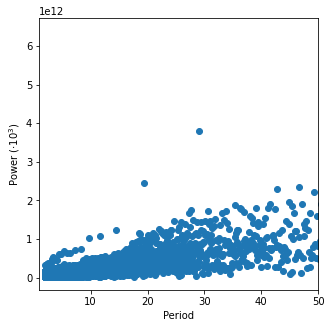

In [591]:
ft_targets = fftpack.fft(reduced_df[target_cols], axis=0)
frequencies = fftpack.fftfreq(reduced_df[target_cols].shape[0],1)
periods = 1 / frequencies

periodicity_find=pd.DataFrame(abs(ft_targets) * 1e-3,columns=target_cols)
periodicity_find['periods']=periods

plt.figure(figsize=(5,5))


plt.plot(periodicity_find['periods'], periodicity_find[target_cols], 'o')
plt.xlim(1, 50)
plt.xlabel('Period')
plt.ylabel('Power ($\cdot10^3$)')

plt.show()

In [415]:
# periodicity_find[((periodicity_find['periods']>0) & (periodicity_find['periods']<50))].max()

In [416]:
# periodicity_find[((periodicity_find['periods']>0) & (periodicity_find['periods']<50))].idxmax()

In [417]:
opt_period=np.rint(periodicity_find.loc[528,'periods'])

In [418]:
#time constant t_r=0.35*period
t_r=opt_period*0.35

In [419]:
print('Time constant is equal to %d (highest period in the power spectrum times 0.35)' %t_r)

Time constant is equal to 10 (highest period in the power spectrum times 0.35)


In [420]:
window=np.rint(t_r/2).astype(np.int64)

In [421]:
print('Optimal window length is %d (approximately half of the time constant)' %window)

Optimal window length is 5 (approximately half of the time constant)


# PART 3

# First train the model for nontarget subjects (Rest of the World)

There are two ways to solve time-series panel data: either loop throughout the model for each country’s data or the countries’ panel data once. If you try both and obtain the RMSE for each way, you can compare the result and choose the best way for your time series panel data.

Let's first train the LSTM model with Global Dataset

In [720]:
#SCALE FEATURES 

In [721]:
s=MinMaxScaler()
Xs=s.fit_transform(reduced_df.drop(columns=['SUBJECT','DATE']))
Ys=Xs

In [722]:
X=[]
Y=[]

In [723]:
subject_lists=reduced_df['SUBJECT'].unique().tolist()

subject_range_list=[]

for subject in subject_lists:
    range_subject=reduced_df.index[reduced_df['SUBJECT']==subject].tolist()
    
    if not subject in target_subjects:
        start=range_subject[0]
        end=range_subject[-1]
        
        for i in range(start+window,end+1):
            X.append(Xs[i-window:i,:])
            Y.append(Ys[i])
            subject_range_list.append(i)

In [724]:
X, Y =np.array(X), np.array(Y)

In [725]:
model = Sequential()

model.add(LSTM(units=4*Y.shape[1], activation='gelu',input_shape=(X.shape[1], X.shape[2]), return_sequences=True ))
model.add(Dropout(0.2))

model.add(LSTM(units=2*Y.shape[1], activation='gelu',return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(Y.shape[1]))
model.add(Activation("linear"))

model.compile(optimizer="adam",
              loss='mse',
              loss_weights=[1]*len(target_cols) + [0.5]*2 + [0.5]*(Y.shape[1]-len(target_cols)-2)
             )

In [726]:
t0=time.time()

model.fit(X,Y, 
          epochs=50, 
          batch_size=128,  verbose=0, shuffle=False,
         )
        
t1=time.time()
print('Runtime for training the model: %.2f s' %(t1-t0))

Runtime for training the model: 86.69 s


Model loss in each epoch

<AxesSubplot:>

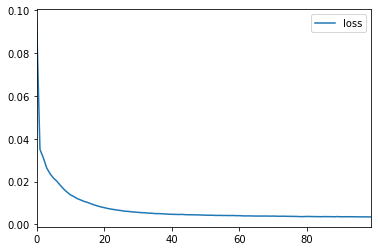

In [727]:
# plot history
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

# Model Evaluation (Rest of The World)

In [629]:
Y_pred=model.predict(X)
Y_pred=s.inverse_transform(Y_pred)
Y_pred=pd.DataFrame(Y_pred,index=subject_range_list, columns=reduced_df.drop(columns=['SUBJECT','DATE']).columns)
Y_pred['SUBJECT']=reduced_df.loc[subject_range_list]['SUBJECT']
Y_pred['DATE']=reduced_df.loc[subject_range_list]['DATE']
Y_pred=Y_pred[reduced_df.columns]
Y=reduced_df.loc[subject_range_list]

How model performed for total for Rest of The World:

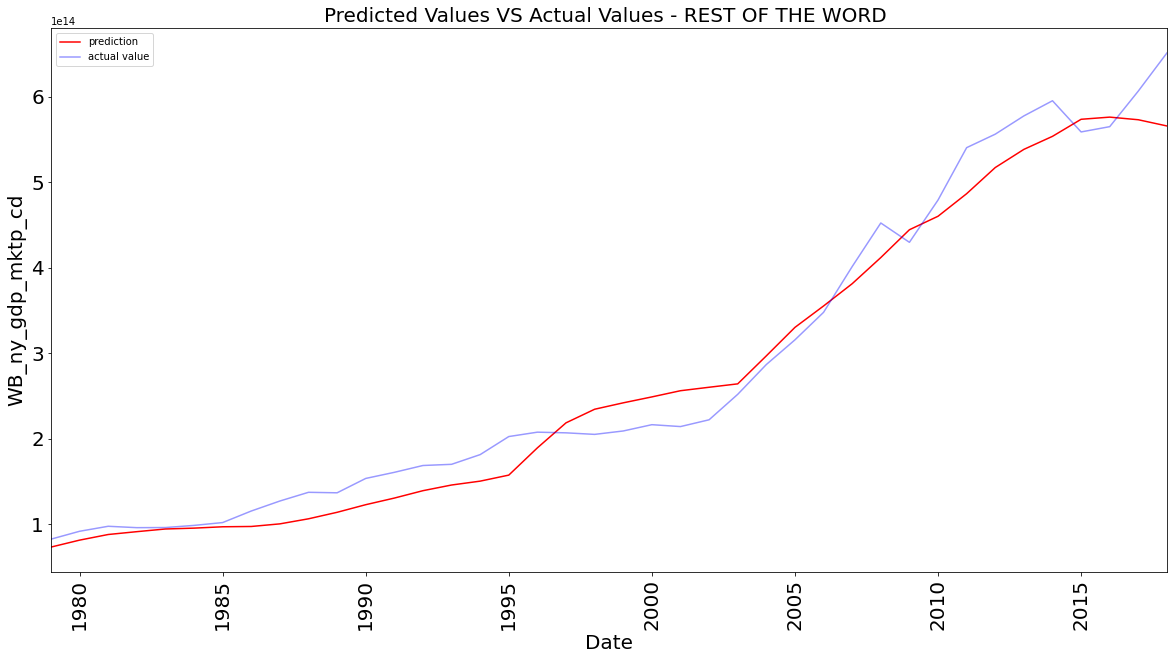

In [631]:
plt.figure(figsize=(20,10))
Y_pred.groupby('DATE')[target_cols[0]].sum()[-40:].plot(kind='line',label='prediction',color='red',alpha=1)
Y.groupby('DATE')[target_cols[0]].sum()[-40:].plot(kind='line',label='actual value',color='blue',alpha=0.4)
plt.xticks(rotation=90,size=20)
plt.yticks(size=20)

plt.ylabel(target_cols[0],fontsize=20)
plt.xlabel('Date',fontsize=20)
plt.title('Predicted Values VS Actual Values - REST OF THE WORD ',fontsize=20)
plt.legend()
 

In [632]:
def RMSE(actual,prediction):
    rmse = np.sqrt(mean_squared_error(actual,prediction))
    return rmse

In [638]:
print('RMSE is %d' %RMSE(Y[target_cols[0]],Y_pred[target_cols[0]]))

RMSE is 1075992814248


In [639]:
#Defining MAPE function
def MAPE(actual,prediction):
    mape = np.mean(np.abs((actual - prediction)/actual))
    return mape

In [640]:
print('MAPE is %d' %MAPE(Y[target_cols[0]],Y_pred[target_cols[0]]))

MAPE is 263


# BACKTESTING TARGET COUNTRIES

LSTM for Target Subjects

Train Test Split and Back Testing for Target Countries

In [641]:
#create a train test split for given subject
def train_test_split(subject, percent=0.8):
    X_train=[]
    Y_train=[]
    X_test=[]
    Y_test=[]
    
    range_subject=reduced_df.index[reduced_df['SUBJECT']==subject].tolist()
    subject_test_range_list=[]
    
    start_train=range_subject[0]
    size=int((range_subject[-1]-range_subject[0])*percent)
    end_train=range_subject[size]
    
    for i in range(start_train+window,end_train+1):
        X_train.append(Xs[i-window:i,:])
        Y_train.append(Ys[i])        

    start_test=range_subject[size+1]
    end_test=range_subject[-1]
    
    for i in range(start_test,end_test+1):
        X_test.append(Xs[i-window:i,:])
        Y_test.append(Ys[i])
        subject_test_range_list.append(i) 
    
    X_train,Y_train,X_test,Y_test =np.array(X_train), np.array(Y_train),np.array(X_test), np.array(Y_test)
    
    return X_train, Y_train, X_test, Y_test, subject_test_range_list

Epoch 00015: early stopping
Epoch 00018: early stopping


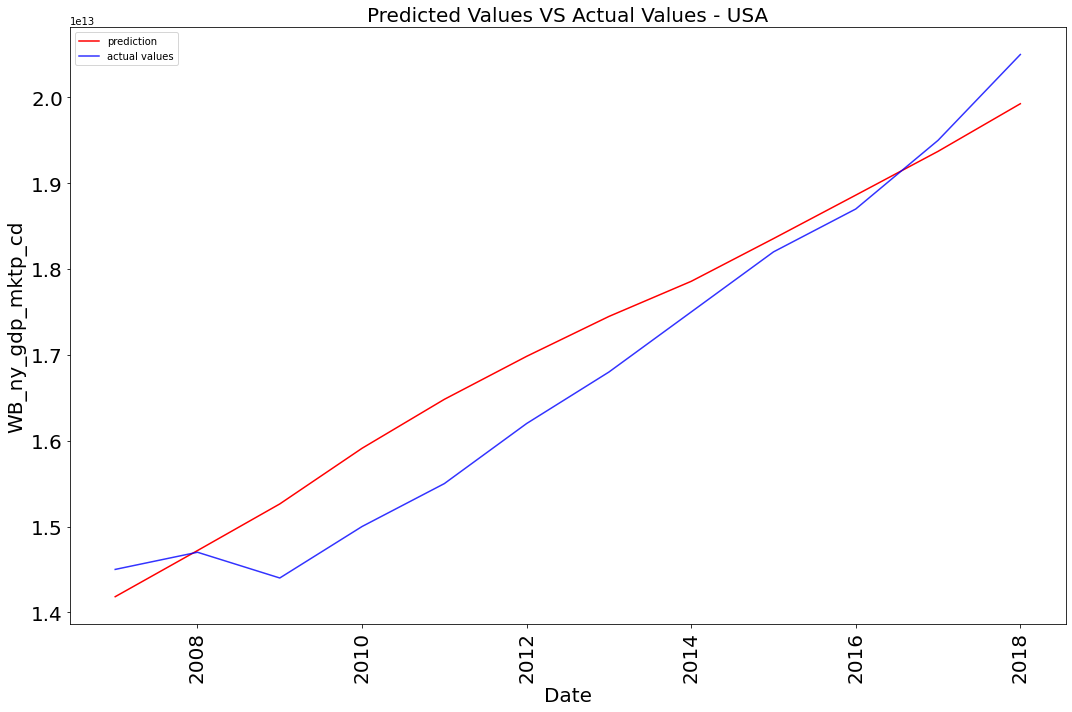

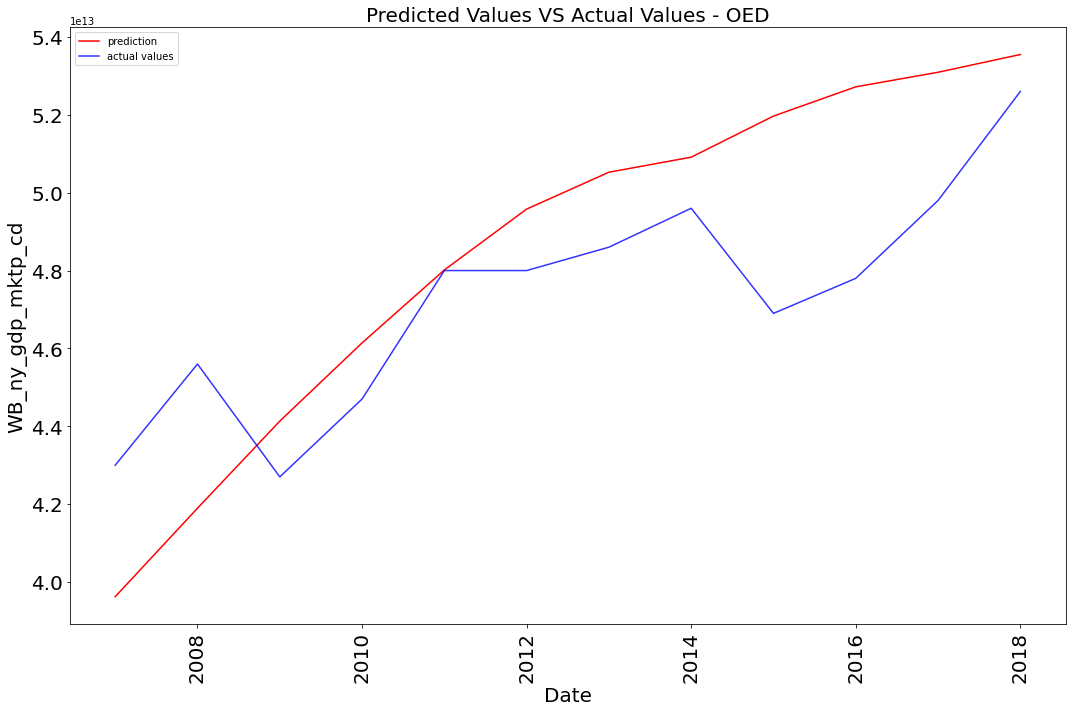

In [736]:
# loop through target subjects
for i, subject in enumerate(target_subjects):
    X_train, Y_train, X_test, Y_test, subject_test_range_list = train_test_split(subject)
    
    early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    
    t0=time.time()
    model.fit(X_train,Y_train, 
              epochs=100, 
              batch_size=8,  verbose=0, shuffle=False,
              validation_data=(X_test, Y_test),
              callbacks=[early_stop])
    t1=time.time()
#     print('Runtime: %.2f s' %(t1-t0))
    Y_test_pred=model.predict(X_test)
    Y_test_pred=s.inverse_transform(Y_test_pred)
    Y_test_pred=pd.DataFrame(Y_test_pred,index=subject_test_range_list, columns=reduced_df.drop(columns=['SUBJECT','DATE']).columns)
    Y_test_pred['SUBJECT']=reduced_df.loc[subject_test_range_list]['SUBJECT']
    Y_test_pred['DATE']=reduced_df.loc[subject_test_range_list]['DATE']
    Y=reduced_df.loc[subject_test_range_list]

    
    plt.figure(figsize=(15,10))
    plt.plot('DATE',target_cols[0], data=Y_test_pred, label='prediction',color='red',alpha=1)
    plt.plot('DATE',target_cols[0], data=Y, label='actual values',color='blue',alpha=0.8)
    
    plt.xticks(rotation=90,size=20)
    plt.yticks(size=20)
    
    
    plt.ylabel(target_cols[0],fontsize=20)
    plt.xlabel('Date',fontsize=20)
    plt.title('Predicted Values VS Actual Values - %s' %(subject),fontsize=20)
    plt.legend()
    
    plt.tight_layout()


The plot shows the predicted values versus actual values.

# FORECAST

We forecast next 3 periods for each target county.

In [735]:
#First fit model for test data then create a forcast for next periods

for subject in target_subjects:
    X_train, Y_train, X_test, Y_test, subject_test_range_list = train_test_split(subject)
    
    model.fit(X_test,Y_test, 
              epochs=100, 
              batch_size=16,  verbose=0, shuffle=False,
             ) 

In [85]:
#Using predicted values to predict next step

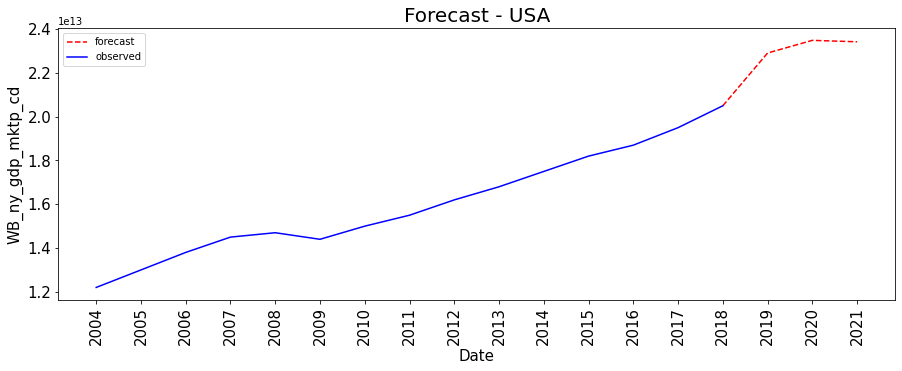

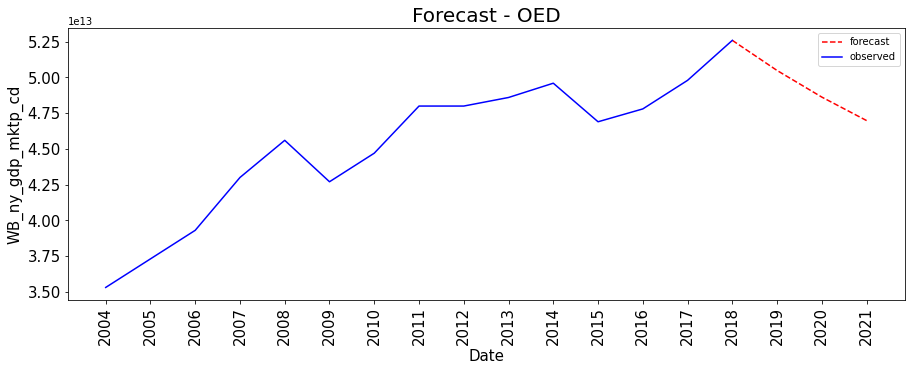

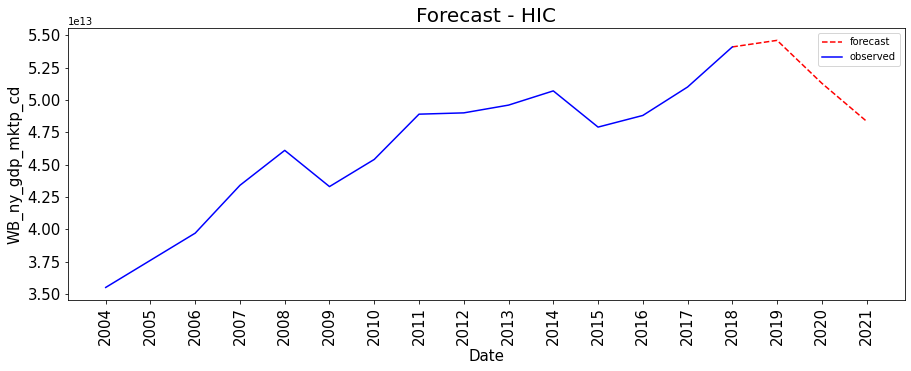

In [553]:
for i, subject in enumerate(target_subjects):
    
    Yf=[]
    range_subject=reduced_df.index[reduced_df['SUBJECT']==subject].tolist()
    
    start=range_subject[-1]
    
    X=Xs[start+1-window:start+1,:].copy()
    Yf.append(X[-1])
    for j in range(window,window+target_periods):
        Xin=X[j-window:j].reshape((1,window,-1))
        X=np.append(X,model.predict(Xin)).reshape((-1,Xin.shape[2]))
        Yf.append(X[-1])
    
    Yf=s.inverse_transform(Yf)
    
    Yf=pd.DataFrame(Yf, columns=reduced_df.drop(columns=['SUBJECT','DATE']).columns)
    Yf['SUBJECT']=reduced_df.loc[start]['SUBJECT']
    Yf['DATE']=range(reduced_df.loc[start]['DATE'],reduced_df.loc[start]['DATE']+1+target_periods)
        
    fig=plt.figure(figsize=(15,5))
    plt.plot('DATE',target_cols[0], data=Yf,label='forecast',color='red',alpha=1,linestyle = '--')

    plt.yticks(size=15)
    

    Xf=reduced_df.loc[range_subject[-5*target_periods:]]
    plt.plot('DATE',target_cols[0], data=Xf,label='observed',color='blue',alpha=1)

    dates=range(reduced_df.loc[start-5*target_periods+1]['DATE'],reduced_df.loc[start]['DATE']+1+target_periods)
    plt.xticks(dates,rotation=90,size=15)
    
    
    plt.ylabel(target_cols[0],fontsize=15)
    plt.xlabel('Date',fontsize=15)
    plt.title('Forecast - %s' %(subject),fontsize=20)
    plt.legend()  
    pickle.dump(fig, open(names[i], 'wb'))